## This notebook uses the current data selection framework to build batting_runs inferential_models

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import os
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor/notebooks'

In [3]:
os.chdir("..")
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [4]:
from utils.config_utils import ConfigUtils
from historical_data.singleton import Helper
from data_selection.data_selection import DataSelection
from rewards_configuration.rewards_configuration import RewardsConfiguration
from simulators.perfect_simulator import PerfectSimulator

In [147]:
import aesara.tensor as at

In [1072]:
config_utils = ConfigUtils(".streamlit/config.toml")
helper = Helper(config_utils)
data_selection = DataSelection(helper)
rewards_config = RewardsConfiguration(config_utils)
perfect_simulator = PerfectSimulator(data_selection, rewards_config)

2022-11-13 20:01:05.100 INFO    root: Creating feedback form storage with method local


In [1184]:
all_matches = data_selection.get_all_matches()

In [1185]:
start_date = all_matches.date.min()
end_date = all_matches.date.max()

In [1186]:
helper.tournaments.set_selected_tournament_names(helper.tournaments.df['name'].to_list())

In [1187]:
helper.tournaments.set_start_end_dates(start_date, end_date, True)

In [1188]:
frequent_players_universe = data_selection.get_frequent_players_universe()

In [1189]:
frequent_players_universe.shape

(134, 19)

In [1190]:
frequent_players_universe.query('featured_player == True').shape

(110, 19)

In [1191]:
frequent_players_universe.index

Index(['AAr1948', 'AAs1113', 'AFf997', 'AGt990', 'AHl2673', 'ANl2414',
       'APe2767', 'ARq809', 'ASs1696', 'ASs992',
       ...
       'TBn798', 'TDn101', 'THn2630', 'VSg740', 'VSi1816', 'WHs2418',
       'WTa1105', 'WVs1108', 'YKn911', 'ZKn743'],
      dtype='object', name='player_key', length=134)

In [1192]:
frequent_players_set = set(frequent_players_universe.query('featured_player == True').index.tolist())

In [1193]:
bowling_outcomes_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(True)

In [1194]:
match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(True)

In [1195]:
match_state_df.iloc[:1]

,,,,batter,bowler,batting_team,total_runs,is_wicket,target_runs,target_overs,batting_featured_player,bowling_featured_player,venue,...,bowler_SCl700,bowler_SFg1109,batter_SHn1817,bowler_VSi1816,bowler_WHs2418,bowler_WTa1105,total_balls_bowled,current_total,wickets_fallen,runs_to_target
match_key,inning,over,ball,,,,,,,,,,,,,,,,,,,,,
211028,1,0,1,MTk1695,BLe850,England,0,0,-1,-1,True,True,"The Rose Bowl, Southampton",...,0,0,0,0,0,0,0,0,0,-1


In [1196]:
all_dates = all_matches.date.sort_values().tolist()

In [1197]:
train_idx = 10

In [1198]:
train_start_date = all_dates[0]
train_end_date = all_dates[train_idx-1]
helper.tournaments.set_start_end_dates(train_start_date, train_end_date, False)

In [1199]:
test_start_date = all_dates[train_idx]
test_end_date = all_dates[train_idx+100]
helper.tournaments.set_start_end_dates(test_start_date, test_end_date, True)

In [1200]:
test_start_date

datetime.date(2006, 12, 26)

In [1201]:
def get_innings_data(bowling_outcomes_df, match_state_df, inning):
    bowling_outcomes_innings_df = bowling_outcomes_df.query(f'inning == {inning}')
    match_state_innings_df = match_state_df.query(f'inning == {inning}')
    return bowling_outcomes_innings_df, match_state_innings_df

In [1202]:
train_bowling_outcomes_by_ball_and_innings_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)

In [1203]:
train_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(False)
train_first_innings_dfs = get_innings_data(train_bowling_outcomes_by_ball_and_innings_df,
                                     train_match_state_df,
                                     inning=1)

In [1204]:
train_match_state_df.iloc[:1]

,,,,batter,bowler,batting_team,total_runs,is_wicket,target_runs,target_overs,batting_featured_player,bowling_featured_player,venue,...,bowler_VSi1816,bowler_WHs2418,bowler_WTa1105,batter_WVs1108,bowler_YKn911,batter_ZKn743,total_balls_bowled,current_total,wickets_fallen,runs_to_target
match_key,inning,over,ball,,,,,,,,,,,,,,,,,,,,,
211028,1,0,1,MTk1695,BLe850,England,0,0,-1,-1,True,True,"The Rose Bowl, Southampton",...,0,0,0,0,0,0,0,0,0,-1


In [1205]:
test_bowling_outcomes_by_ball_and_innings_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(True)

In [1206]:
test_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(True)
test_first_innings_dfs = get_innings_data(test_bowling_outcomes_by_ball_and_innings_df,
                                     test_match_state_df,
                                     inning=1)

## Building new features and targets

In [1207]:
def batter_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'batter_featured_id'] = df['batter']
    df['batter_featured_id'].fillna('non_frequent_player',inplace=True)
    
def bowler_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'bowler_featured_id'] = df['bowler']
    df['bowler_featured_id'].fillna('non_frequent_player',inplace=True)
    
def is_legal_delivery(df):
    c1 = df.noballs.isna() 
    c2 = df.wides.isna()
    df.loc[c1&c2,'is_legal_delivery'] = True
    df['is_legal_delivery'].fillna(False,inplace=True)
    
def striker_dismissed(df):
    c1 = (df['batter'] == df['player_dismissed'])
    c2 = (df['player_dismissed'].isna()==False)
    df.loc[c1&c2,'striker_dismissed'] = True
    c3 = (df['batter'] != df['player_dismissed'])
    df.loc[c3 & c2,'striker_dismissed'] = False
    
def add_column_to_df(df,
                     column_name):
    column_name(df)

In [1208]:
for df in [match_state_df,
           train_match_state_df,
           test_match_state_df]:
    for column in [batter_featured_id,
                   bowler_featured_id]:
        add_column_to_df(df,
                         column)

In [1209]:
for df in [bowling_outcomes_df,
           train_bowling_outcomes_by_ball_and_innings_df,
           test_bowling_outcomes_by_ball_and_innings_df]:
    for column in [is_legal_delivery,
                   striker_dismissed]:
        add_column_to_df(df,
                         column)

## Calculate some generic frequencies

In [1006]:
pre_combined_df = pd.merge(bowling_outcomes_df,
                           match_state_df,
                           left_index = True,
                           right_index = True)

In [1007]:
pre_combined_df

batter_runs  extras  total_runs_x non_boundary  \
match_key inning over ball                                                   
211028    1      0    1               0       0             0          NaN   
                      2               1       0             1          NaN   
                      3               0       0             0          NaN   
                      4               0       0             0          NaN   
                      5               0       0             0          NaN   
...                                 ...     ...           ...          ...   
1336032   2      19   4               1       0             1          NaN   
                      5               0       2             2          NaN   
                      6               0       1             1          NaN   
                      7               0       0             0          NaN   
                      8               2       0             2          NaN   

                            is_wicket_x dismissal_kind  is_direct_runout  \
match_key inning over ball                                                 
211028    1      0    1               0            NaN               NaN   
                      2               0            NaN               NaN   
                      3               0            NaN               NaN   
                      4               0            NaN               NaN   
                      5               0            NaN               NaN   
...                                 ...            ...               ...   
1336032   2      19   4               0            NaN               NaN   
                      5               0            NaN               NaN   
                      6               0            NaN               NaN   
                      7               0            NaN               NaN   
                      8               0            NaN               NaN   

                            byes  legbyes  noballs  ...  bowler_ZGn1517  \
match_key inning over ball                          ...                   
211028    1      0    1      NaN      NaN      NaN  ...               0   
                      2      NaN      NaN      NaN  ...               0   
                      3      NaN      NaN      NaN  ...               0   
                      4      NaN      NaN      NaN  ...               0   
                      5      NaN      NaN      NaN  ...               0   
...                          ...      ...      ...  ...             ...   
1336032   2      19   4      NaN      NaN      NaN  ...               0   
                      5      NaN      NaN      NaN  ...               0   
                      6      NaN      NaN      NaN  ...               0   
                      7      NaN      NaN      NaN  ...               0   
                      8      NaN      NaN      NaN  ...               0   

                            bowler_ZHn2712 bowler_ZKn1926 batter_ZSd2789  \
match_key inning over ball                                                 
211028    1      0    1                  0              0              0   
                      2                  0              0              0   
                      3                  0              0              0   
                      4                  0              0              0   
                      5                  0              0              0   
...                                    ...            ...            ...   
1336032   2      19   4                  0              0              0   
                      5                  0              0              0   
                      6                  0              0              0   
                      7                  0              0              0   
                      8                  0              0              0   

                           total_balls_bowled current_total

In [1008]:
legal_ball = (pre_combined_df['is_legal_delivery'] == True)
wicket_ball = (pre_combined_df['is_wicket_x'] == True)

In [1009]:
pre_combined_df.loc[legal_ball&wicket_ball]['batter_runs'].value_counts(dropna=False,normalize=True)

0    0.970653
1    0.027396
2    0.001666
4    0.000135
6    0.000105
3    0.000045
Name: batter_runs, dtype: float64

In [1010]:
pre_combined_df.loc[legal_ball&wicket_ball]['extras'].value_counts(dropna=False,normalize=True)

0    0.99958
1    0.00039
2    0.00003
Name: extras, dtype: float64

In [1012]:
pre_combined_df['dismissal_kind'].value_counts(normalize=True)

caught                   0.603847
bowled                   0.188669
run out                  0.078145
lbw                      0.067272
stumped                  0.030660
caught and bowled        0.028805
retired hurt             0.001286
hit wicket               0.001017
obstructing the field    0.000120
retired not out          0.000105
retired out              0.000075
Name: dismissal_kind, dtype: float64

In [1014]:
runout_ball = (pre_combined_df['dismissal_kind'] == 'run out')

In [1015]:
pre_combined_df.loc[runout_ball]['striker_dismissed'].value_counts(dropna=False,normalize=True)

True     0.532632
False    0.467368
Name: striker_dismissed, dtype: float64

In [1017]:
illegal_ball = (pre_combined_df['is_legal_delivery'] == False)

In [1018]:
pre_combined_df.loc[illegal_ball]['noballs'].value_counts(dropna=False,normalize=True)

NaN    0.876193
1.0    0.090318
2.0    0.031924
3.0    0.000581
5.0    0.000514
6.0    0.000447
4.0    0.000022
Name: noballs, dtype: float64

In [1019]:
pre_combined_df.loc[illegal_ball]['wides'].value_counts(dropna=False,normalize=True)

1.0    0.799110
NaN    0.123807
2.0    0.036753
5.0    0.030382
3.0    0.008495
4.0    0.001453
Name: wides, dtype: float64

In [1020]:
pre_combined_df.loc[illegal_ball]['batter_runs'].value_counts(dropna=False,normalize=True)

0    0.934810
1    0.034093
4    0.014822
6    0.008361
2    0.007556
3    0.000358
Name: batter_runs, dtype: float64

In [1021]:
pre_combined_df.loc[illegal_ball]['extras'].value_counts(dropna=False,normalize=True)

1    0.887394
2    0.068968
5    0.031701
3    0.009635
4    0.001520
6    0.000760
7    0.000022
Name: extras, dtype: float64

In [1022]:
pre_combined_df.loc[illegal_ball&wicket_ball]['batter_runs'].value_counts(dropna=False,normalize=True)

0    0.97166
1    0.02834
Name: batter_runs, dtype: float64

In [1023]:
pre_combined_df.loc[illegal_ball&wicket_ball]['extras'].value_counts(dropna=False,normalize=True)

1    0.971660
2    0.024291
5    0.004049
Name: extras, dtype: float64

## Building Categoricals for Indexing

In [1210]:
def build_categoricals_for_column(df,column):
    categorical = pd.Categorical(df[column])
    return categorical.categories
    
def get_categorical_column_index_for_df(df,
                            categories,
                            column):
    idx = pd.Categorical(df[column],
                         categories).codes
    return idx

In [1211]:
COORDS = {}
train_feature_data = {}
test_feature_data = {}
all_feature_data = {}
for dim in ['batter_featured_id',
            'bowler_featured_id',
            'batting_team',
            'bowling_team',
            'venue',
            'wickets_fallen']:
    categories = build_categoricals_for_column(match_state_df,
                                               dim)
    COORDS[dim] = categories
    train_feature_data[dim] = get_categorical_column_index_for_df(train_match_state_df,
                                                                  categories,
                                                                  dim)
    test_feature_data[dim] = get_categorical_column_index_for_df(test_match_state_df,
                                                              categories,
                                                              dim)
    all_feature_data[dim] = get_categorical_column_index_for_df(match_state_df,
                                                          categories,
                                                          dim)

In [1212]:
'MTk1695' in frequent_players_set

True

In [1213]:
train_match_state_df.iloc[:1].batter_featured_id

match_key  inning  over  ball
211028     1       0     1       MTk1695
Name: batter_featured_id, dtype: object

In [1214]:
match_state_df.iloc[:1].batter_featured_id

match_key  inning  over  ball
211028     1       0     1       MTk1695
Name: batter_featured_id, dtype: object

In [1215]:
train_feature_data

{'batter_featured_id': array([65, 65, 26, ..., 47, 90, 47], dtype=int8),
 'bowler_featured_id': array([ 180,  180,  180, ..., 1048, 1048, 1048], dtype=int16),
 'batting_team': array([57, 57, 57, ..., 81, 81, 81], dtype=int16),
 'bowling_team': array([  5,   5,   5, ..., 172, 172, 172], dtype=int16),
 'venue': array([183, 183, 183, ..., 126, 126, 126], dtype=int16),
 'wickets_fallen': array([0, 0, 0, ..., 4, 4, 4], dtype=int8)}

In [1216]:
train_outcome_data = {}
test_outcome_data = {}
all_outcome_data = {}
for dim in ['batter_runs',
            'extras',
            'is_legal_delivery',
            'is_wicket',
            'wides',
            'noballs',
            'dismissal_kind',
            'is_direct_runout']:
    categories = build_categoricals_for_column(bowling_outcomes_df,
                                               dim)
    COORDS[dim] = categories
    train_outcome_data[dim] = get_categorical_column_index_for_df(train_bowling_outcomes_by_ball_and_innings_df,
                                                                  categories,
                                                                  dim)
    test_outcome_data[dim] = get_categorical_column_index_for_df(test_bowling_outcomes_by_ball_and_innings_df,
                                                              categories,
                                                              dim)
    all_outcome_data[dim] = get_categorical_column_index_for_df(bowling_outcomes_df,
                                                          categories,
                                                          dim)

In [1217]:
COORDS

{'batter_featured_id': Index(['AAr1948', 'AAs1113', 'AFf997', 'AGt990', 'AHl2673', 'ARq809',
        'ASs1696', 'ASs992', 'AdVs598', 'BLe850',
        ...
        'TBn798', 'TDn101', 'VSg740', 'VSi1816', 'WHs2418', 'WTa1105',
        'WVs1108', 'YKn911', 'ZKn743', 'non_frequent_player'],
       dtype='object', length=104),
 'bowler_featured_id': Index(['AARy3520', 'AAd3073', 'AAd3546', 'AAd907', 'AAi1093', 'AAi3764',
        'AAi3778', 'AAi3790', 'AAi716', 'AAm1821',
        ...
        'ZGr3749', 'ZKn2797', 'ZKn3741', 'ZKn3750', 'ZKn743', 'ZMd2686',
        'ZRn242', 'ZSd2789', 'Zq3805', 'non_frequent_player'],
       dtype='object', length=1379),
 'batting_team': Index(['Adelaide Strikers', 'Afghanistan', 'Antigua Hawksbills', 'Argentina',
        'Auckland', 'Australia', 'Austria', 'Bahamas', 'Bahrain',
        'Balkh Legends',
        ...
        'United States of America', 'Vanuatu', 'Warriors', 'Warwickshire',
        'Wellington', 'West Indies', 'Western Province', 'Worcestershi

In [1218]:
train_match_state_df.batter_featured_id.unique().shape

(85,)

In [1219]:
test_match_state_df.batter_featured_id.unique().shape

(79,)

In [1220]:
train_match_state_df.bowler_featured_id.unique().shape

(77,)

In [1221]:
test_match_state_df.bowler_featured_id.unique().shape

(184,)

In [1222]:
def build_xarray(feature_dict,
                 outcome_dict,
                 index_df):
    feature_df = pd.DataFrame(feature_dict)
    feature_df.index = index_df.index
    outcome_df = pd.DataFrame(outcome_dict)
    outcome_df.index = index_df.index
    combined_df = pd.merge(outcome_df,
                           feature_df,
                           left_index = True,
                           right_index = True)
    return combined_df, combined_df.to_xarray()

In [1223]:
train_combined_df,train_combined_xarray = build_xarray(train_feature_data,
                                                         train_outcome_data,
                                                         train_match_state_df)

In [1224]:
test_combined_df,test_combined_xarray = build_xarray(test_feature_data,
                                                         test_outcome_data,
                                                         test_match_state_df)

In [1225]:
all_combined_df,all_combined_xarray = build_xarray(all_feature_data,
                                                         all_outcome_data,
                                                         match_state_df)

In [1228]:
all_combined_df.batter_runs.isna().sum()

0

In [1483]:
all_combined_xarray.sel(match_key = [211028])

<xarray.Dataset>
Dimensions:             (match_key: 1, inning: 6, over: 20, ball: 14)
Coordinates:
  * match_key           (match_key) int64 211028
  * inning              (inning) int64 1 2 3 4 5 6
  * over                (over) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * ball                (ball) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables: (12/14)
    batter_runs         (match_key, inning, over, ball) float32 0.0 1.0 ... nan
    extras              (match_key, inning, over, ball) float32 0.0 0.0 ... nan
    is_legal_delivery   (match_key, inning, over, ball) float32 1.0 1.0 ... nan
    is_wicket           (match_key, inning, over, ball) float32 0.0 0.0 ... nan
    wides               (match_key, inning, over, ball) float32 -1.0 ... nan
    noballs             (match_key, inning, over, ball) float32 -1.0 ... nan
    ...                  ...
    batter_featured_id  (match_key, inning, over, ball) float32 65.0 ... nan
    bowler_featured_id  (match_key, inning, over, ball) float32 180.0 ... nan
    batting_team        (match_key, inning, over, ball) float32 57.0 ... nan
    bowling_team        (match_key, inning, over, ball) float32 5.0 5.0 ... nan
    venue               (match_key, inning, over, ball) float32 183.0 ... nan
    wickets_fallen      (match_key, inning, over, ball) float32 0.0 0.0 ... nan

## Adding Data to the PyMC Model

In [1645]:
with pm.Model(coords=COORDS) as first_innings_model:
    first_innings_model.add_coord('ball_ids',
                                   values = np.arange(train_combined_df.shape[0]),
                                   mutable = True)
    is_legal_delivery_outcomes_data = pm.MutableData("is_legal_delivery_outcomes_data",
                                                     train_combined_df['is_legal_delivery'],
                                                     dims = 'ball_ids')
    batter_runs_outcomes_data = pm.MutableData("batter_runs_outcomes_data",
                                               train_combined_df['batter_runs'],
                                               dims = 'ball_ids')
    batter_featured_id_feature_data = pm.MutableData("batter_featured_id_feature_data",
                                                     train_combined_df['batter_featured_id'],
                                                     dims = 'ball_ids')
    bowler_featured_id_feature_data = pm.MutableData("bowler_featured_id_feature_data",
                                                 train_combined_df['bowler_featured_id'],
                                                 dims = 'ball_ids')
    venue_feature_data = pm.MutableData("venue_feature_data",
                                        train_combined_df['venue'],
                                        dims = 'ball_ids')
    batting_team_feature_data = pm.MutableData("batting_team_feature_data",
                                    train_combined_df['batting_team'],
                                    dims = 'ball_ids')
    bowling_team_feature_data = pm.MutableData("bowling_team_feature_data",
                                    train_combined_df['bowling_team'],
                                    dims = 'ball_ids')


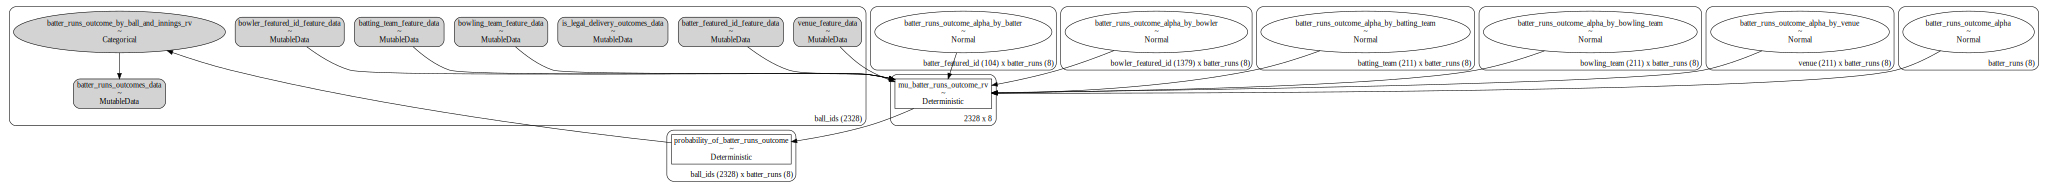

In [1646]:
with first_innings_model:
    batter_runs_outcome_alpha_mu_by_batter_global = 0
    batter_runs_outcome_alpha_sigma_by_batter_global = 3.0
    batter_runs_outcome_alpha_by_batter = pm.Normal('batter_runs_outcome_alpha_by_batter',
                                                    mu = batter_runs_outcome_alpha_mu_by_batter_global,
                                                    sigma = batter_runs_outcome_alpha_sigma_by_batter_global,
                                                    dims = ('batter_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowler = pm.Normal('batter_runs_outcome_alpha_by_bowler',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowler_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_batting_team = pm.Normal('batter_runs_outcome_alpha_by_batting_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('batting_team',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowling_team = pm.Normal('batter_runs_outcome_alpha_by_bowling_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowling_team',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_venue = pm.Normal('batter_runs_outcome_alpha_by_venue',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('venue',
                                                            'batter_runs'))
    
    batter_runs_outcome_alpha = pm.Normal('batter_runs_outcome_alpha',
                                         mu=0,
                                         sigma=3,
                                         dims='batter_runs')
    batter_runs_outcome_mu = pm.Deterministic('mu_batter_runs_outcome_rv',
                                                        batter_runs_outcome_alpha+
                                                        batter_runs_outcome_alpha_by_batter[batter_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_bowler[bowler_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_batting_team[batting_team_feature_data]+
                                                        batter_runs_outcome_alpha_by_bowling_team[bowling_team_feature_data]+
                                                        batter_runs_outcome_alpha_by_venue[venue_feature_data])
    probability_of_batter_runs_outcome_rv = pm.Deterministic('probability_of_batter_runs_outcome',
                                                         at.nnet.softmax(batter_runs_outcome_mu),
                                                         dims = ('ball_ids','batter_runs'))
    batter_outcomes_by_ball_and_innings_rv = pm.Categorical('batter_runs_outcome_by_ball_and_innings_rv',
                                                         p=probability_of_batter_runs_outcome_rv,
                                                         observed=batter_runs_outcomes_data,
                                                         dims = 'ball_ids')

pm.model_to_graphviz(first_innings_model)

In [1647]:
with first_innings_model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
2022-11-14 13:15:03.732 INFO    pymc: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-11-14 13:15:03.742 INFO    pymc: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-11-14 13:15:09.699 INFO    pymc: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_batting_team, batter_runs_outcome_alpha_by_bowling_team, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha]
2022-11-14 13:15:09.701 INFO    pymc: NUTS: [batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_batting_team, batter_runs_outcome_alpha_by_bowling_team, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1958 seconds.
2022-11-14 13:47:48.235 INFO    pymc: Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1958 seconds.


array([[<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n0'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n1'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n2'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n3'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n4'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n5'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n6'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n7'}>]],
      dtype=object)

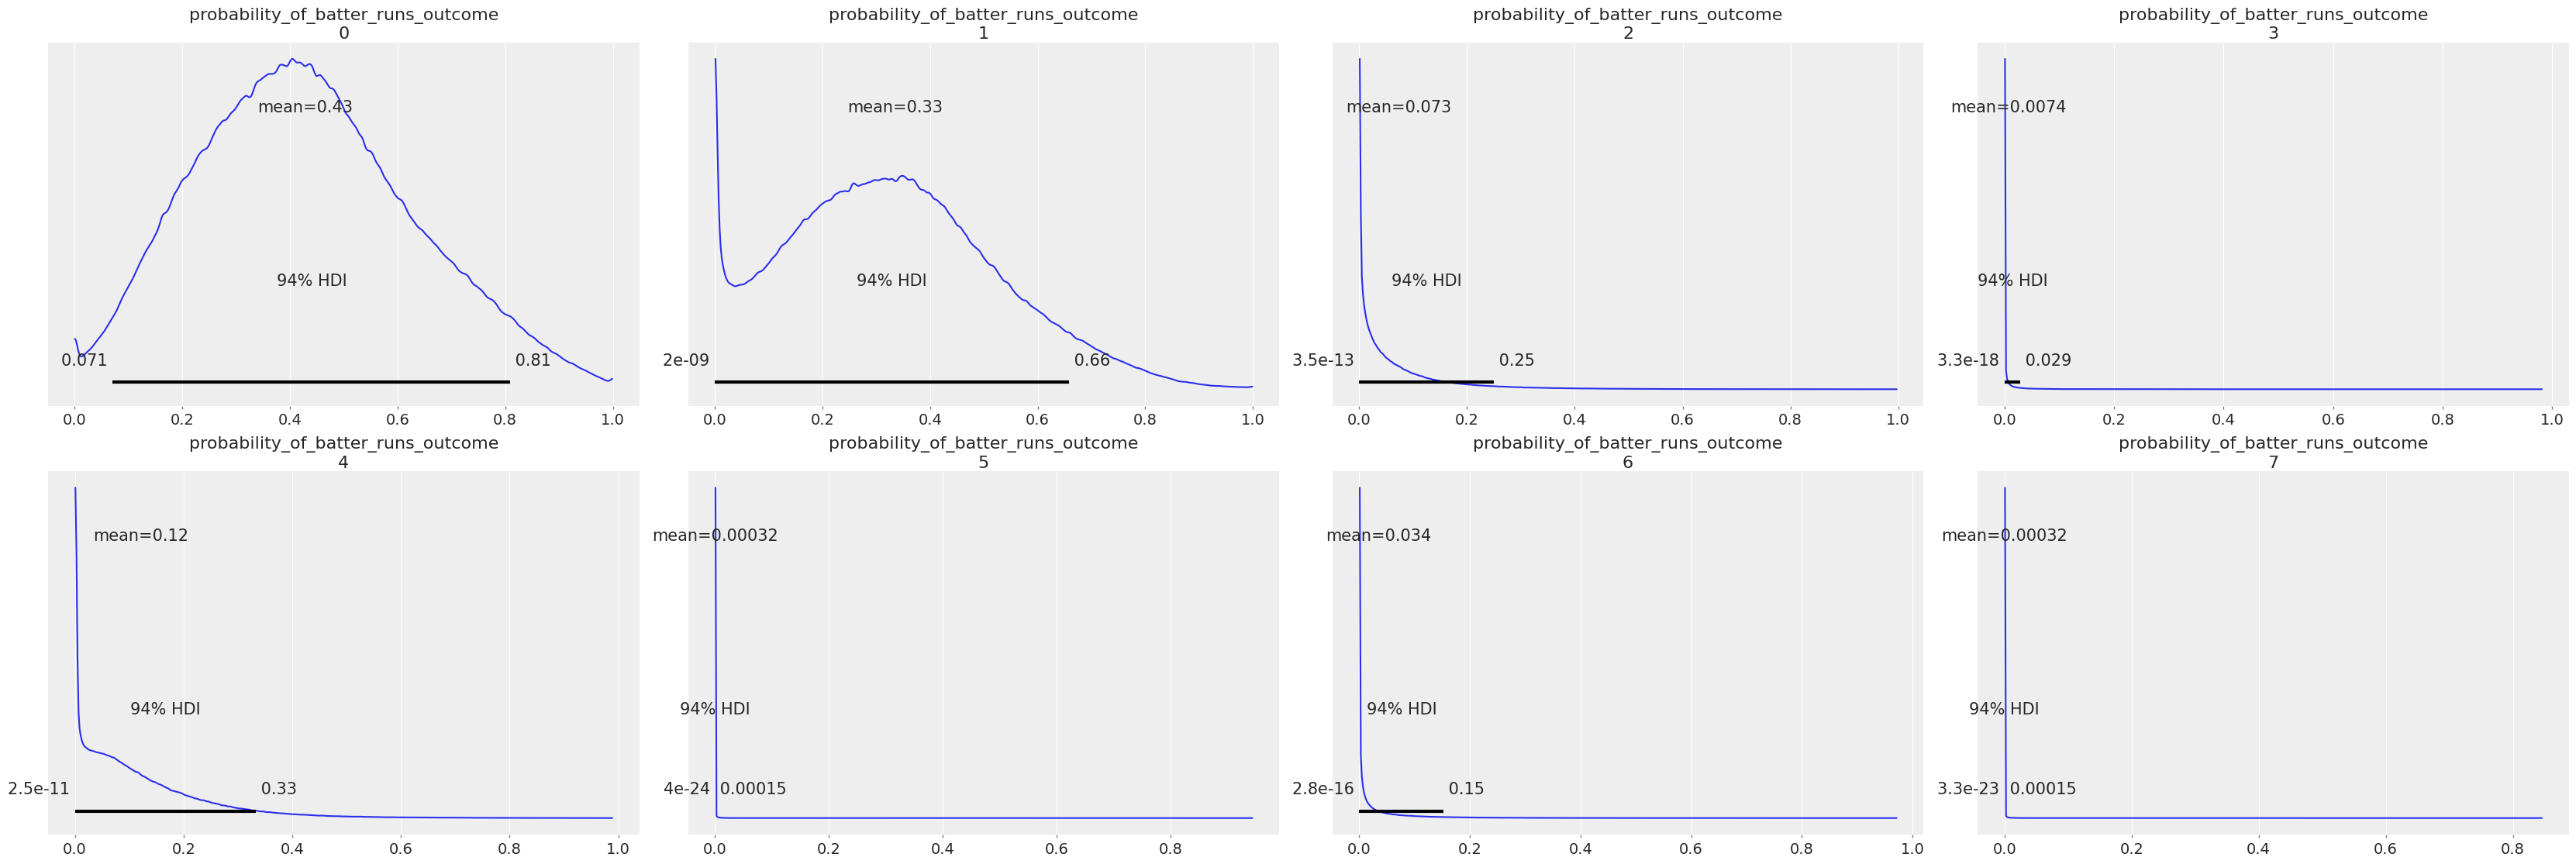

In [1648]:
az.plot_posterior(idata.posterior,
                  var_names = ['probability_of_batter_runs_outcome'],
                  combine_dims = {'chain','draw','ball_ids'})

<AxesSubplot: >

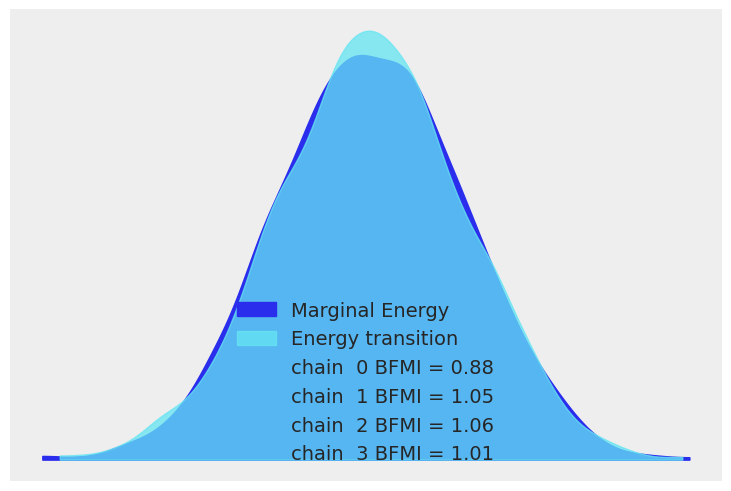

In [1649]:
az.plot_energy(idata)

In [1650]:
with first_innings_model:
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata,random_seed=RANDOM_SEED))

Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_batting_team, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_bowling_team, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_by_ball_and_innings_rv]
2022-11-14 13:50:30.312 INFO    pymc: Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_batting_team, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_bowling_team, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_by_ball_and_innings_rv]
Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-14 13:50:56.836 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


<AxesSubplot: xlabel='batter_runs_outcome_by_ball_and_innings_rv / batter_runs_outcome_by_ball_and_innings_rv'>

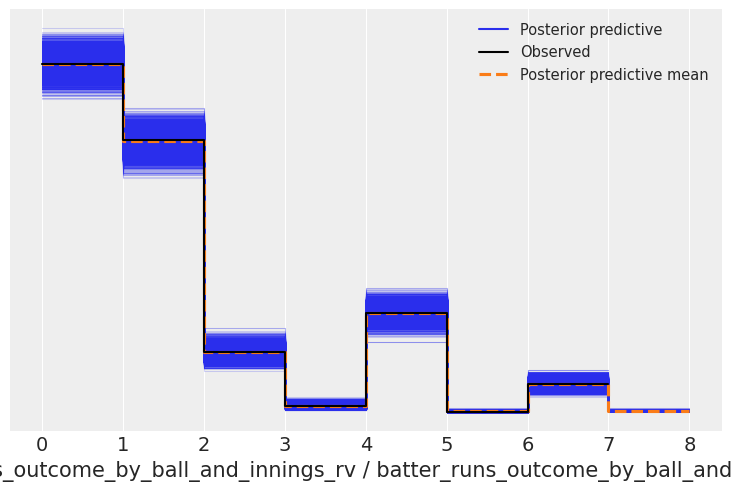

In [1651]:
az.plot_ppc(idata)

In [1652]:
first_innings_model.set_dim('ball_ids',
                             test_combined_df.shape[0],
                             coord_values = np.arange(train_combined_df.shape[0],
                                                      train_combined_df.shape[0]+test_combined_df.shape[0]))

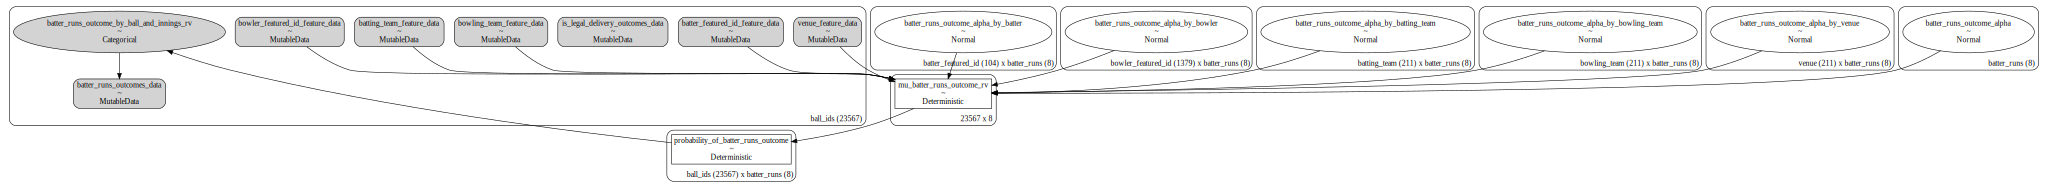

In [1653]:
with first_innings_model:
    pm.set_data({
        'batter_runs_outcomes_data': test_combined_df['batter_runs'],
        "batter_featured_id_feature_data": test_combined_df['batter_featured_id'],
        "bowler_featured_id_feature_data": test_combined_df['bowler_featured_id'],
        "batting_team_feature_data": test_combined_df['batting_team'],
        "bowling_team_feature_data": test_combined_df['bowling_team'],
        "venue_feature_data": test_combined_df['venue'],
        "is_legal_delivery_outcomes_data": test_combined_df['is_legal_delivery']
    })

pm.model_to_graphviz(first_innings_model)

In [1654]:
with first_innings_model:
    idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-14 13:52:44.171 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


array([[<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2328'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2329'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2330'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2331'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2332'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2333'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2334'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2335'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2336'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n2337'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_

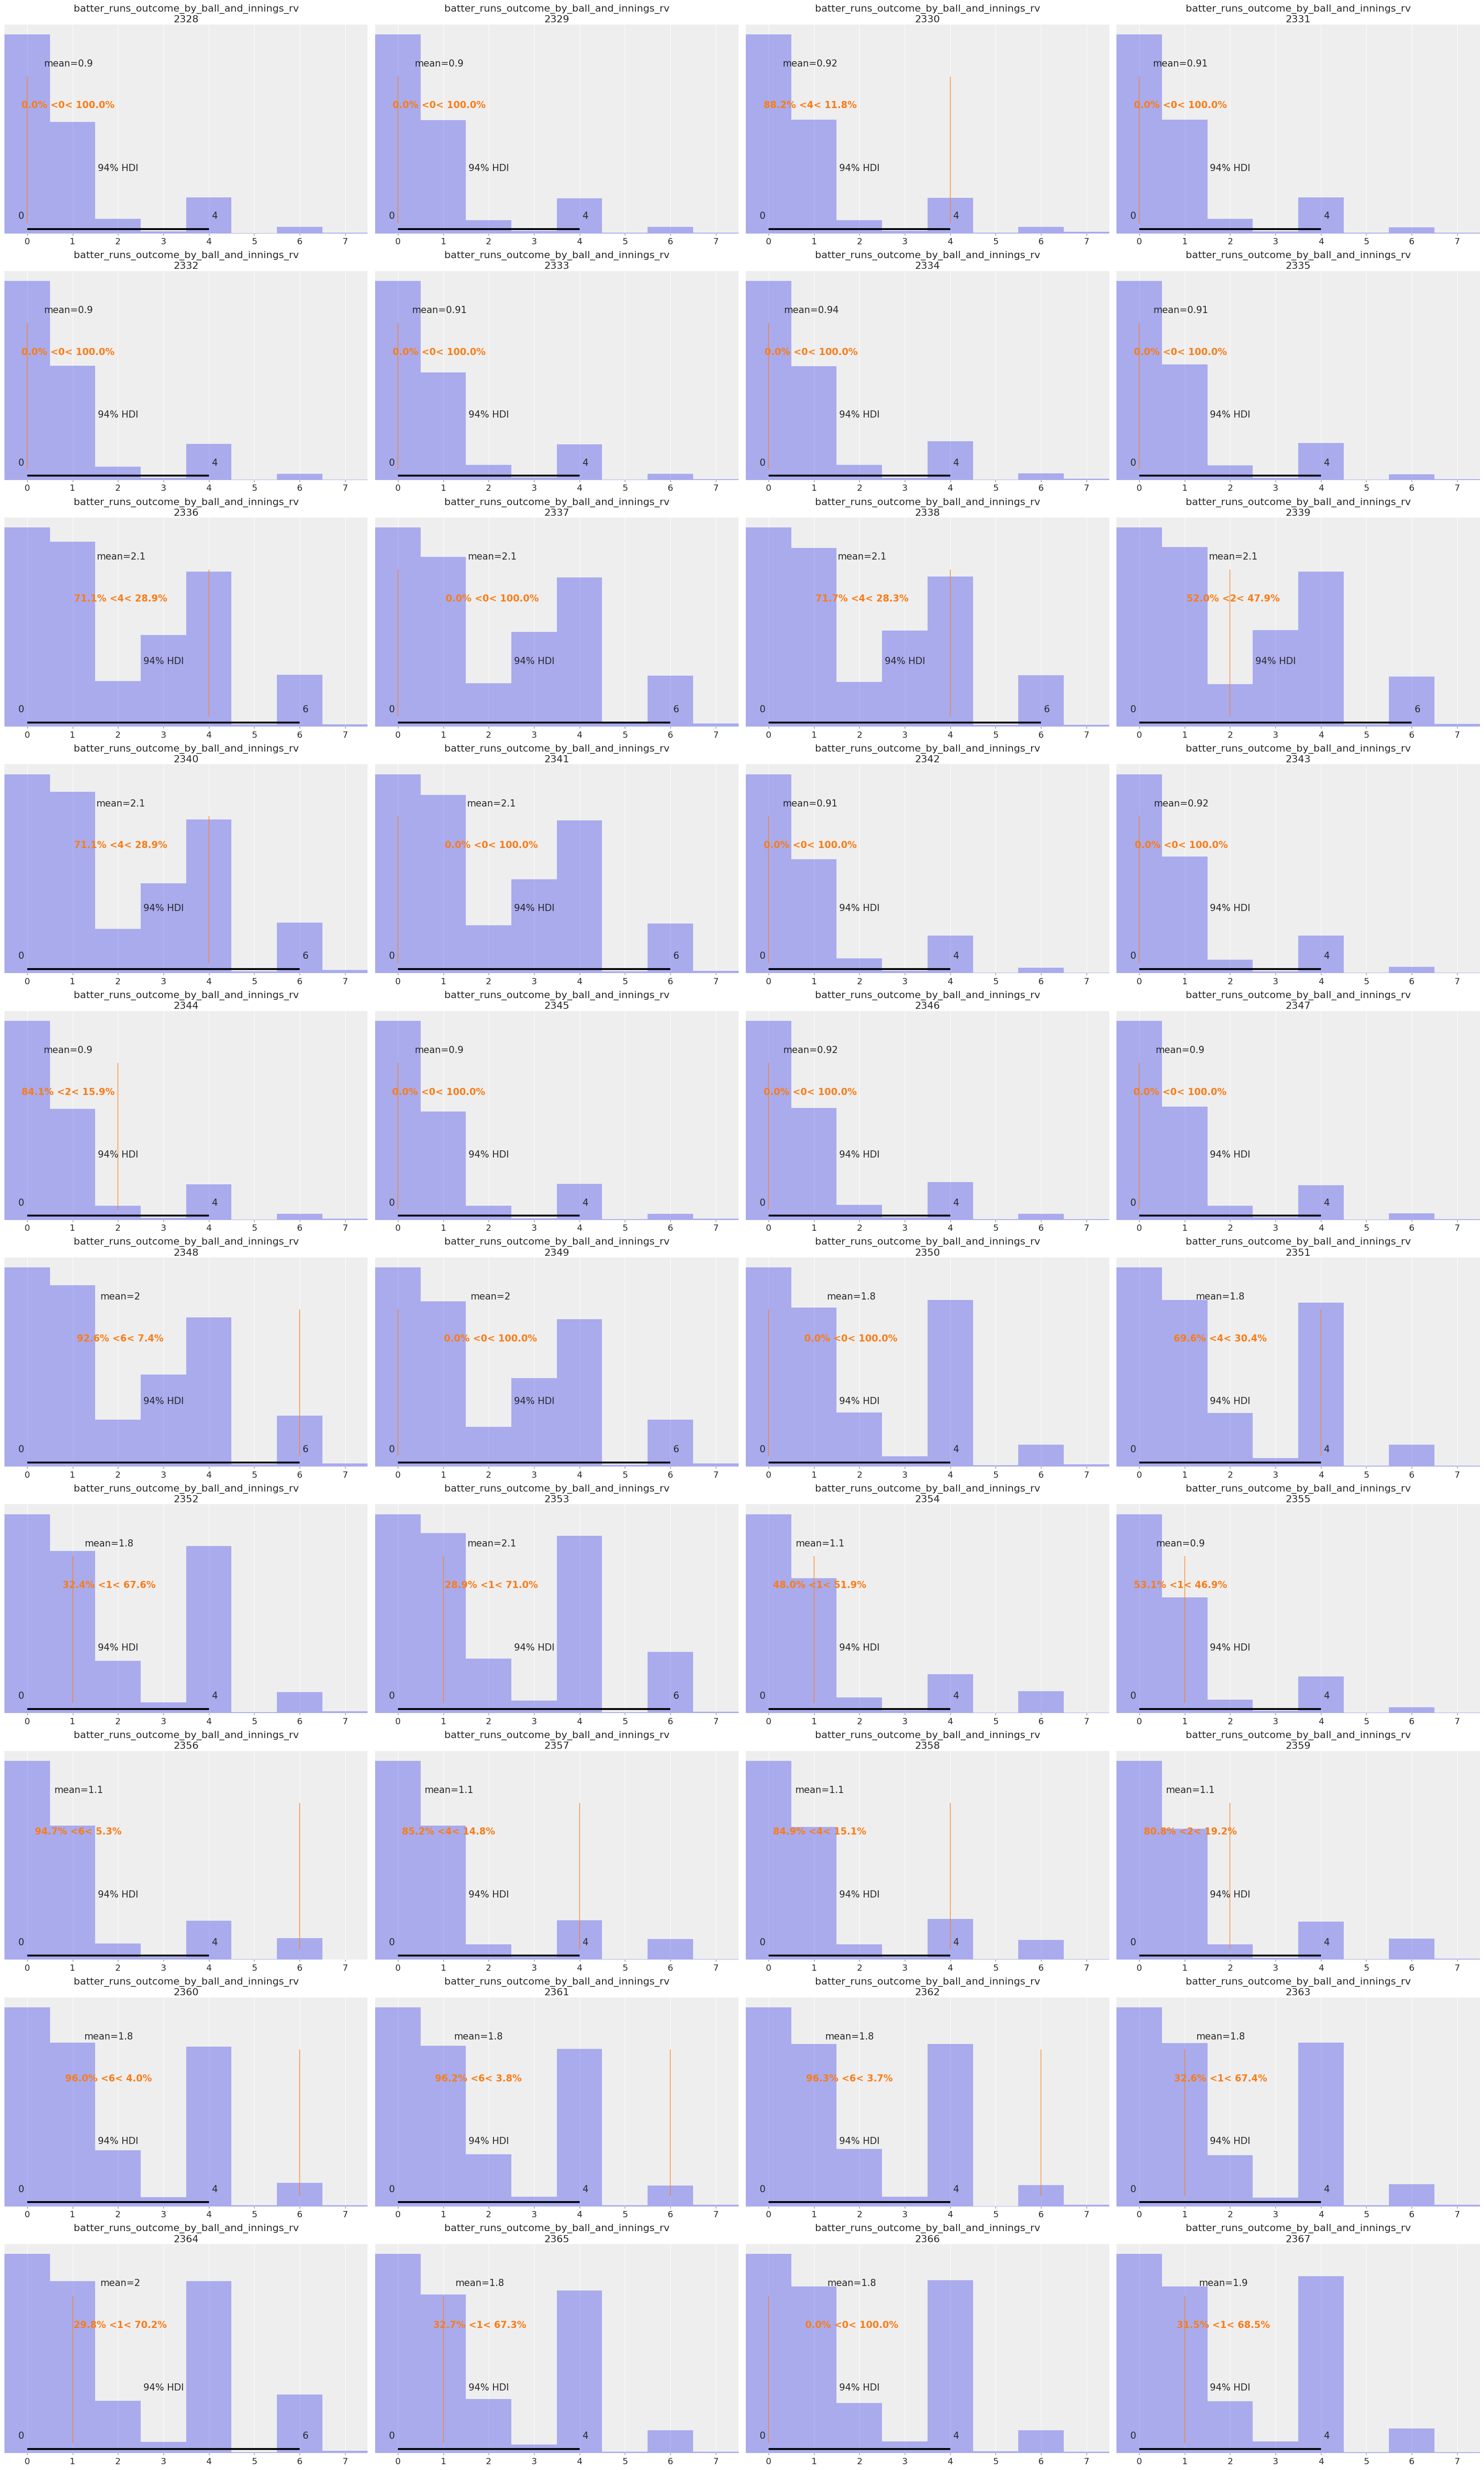

In [1655]:
az.plot_posterior(
    idata.predictions,
    ref_val=test_combined_df.batter_runs.tolist(),
)

<AxesSubplot: >

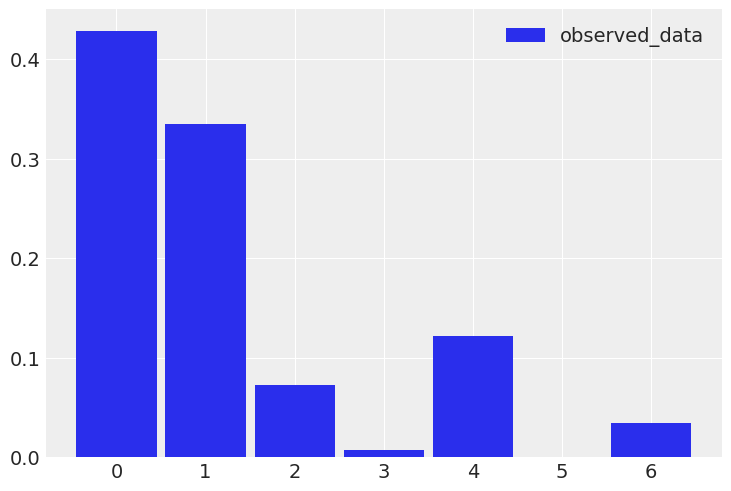

In [1465]:
az.plot_dist(idata.observed_data["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='observed_data')

<AxesSubplot: >

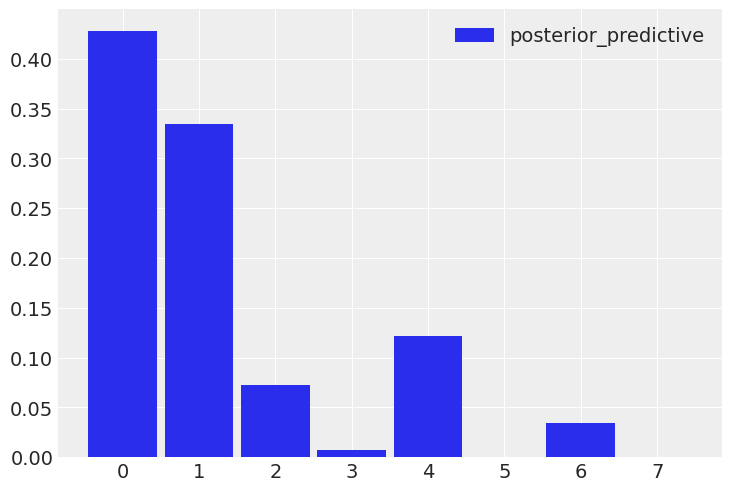

In [1466]:
az.plot_dist(idata.posterior_predictive["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='posterior_predictive')

<AxesSubplot: >

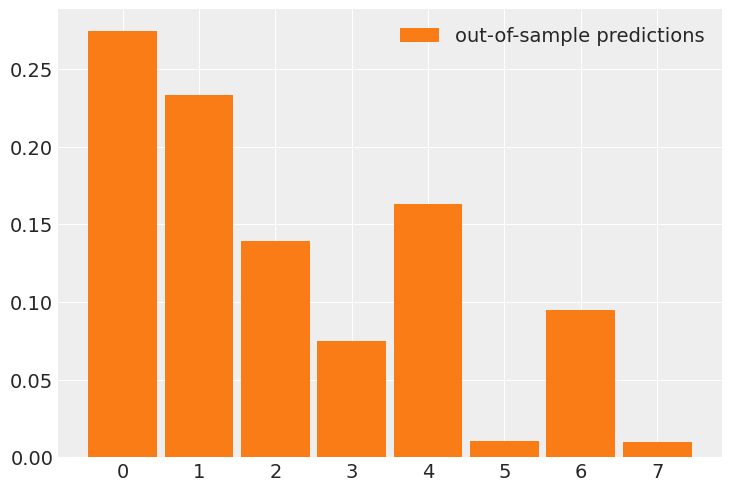

In [1656]:
az.plot_dist(idata.predictions["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C1', 
             label = 'out-of-sample predictions')

<AxesSubplot: >

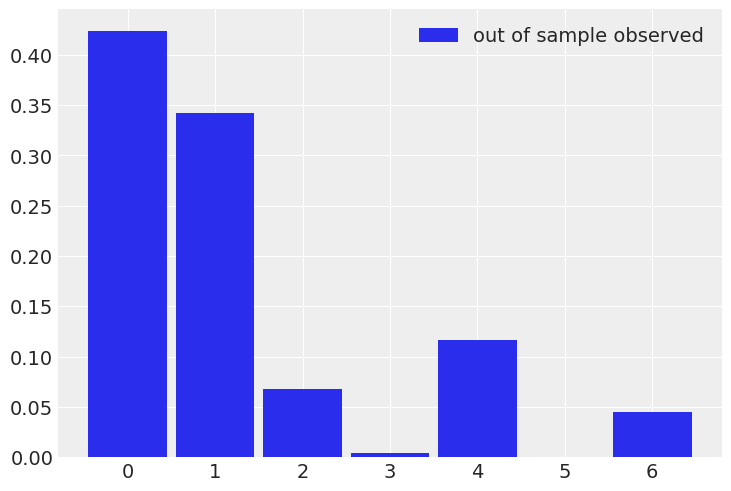

In [1468]:
az.plot_dist(test_batter_runs_outcomes_idx,
             label = 'out of sample observed')

In [1683]:
def predictions_from_idata(idata,
                           var_name):
    preds_helper = lambda ds: ds.to_dataframe()[var_name].value_counts(normalize=True).to_xarray()
    predictions = (
        idata.predictions[var_name]
        .stack(dims=['chain','draw'])
        .groupby('ball_ids')
        .apply(preds_helper)
    )
    return predictions
    

In [1684]:
predictions = predictions_from_idata(idata,
                                     'batter_runs_outcome_by_ball_and_innings_rv')

In [1713]:
predictions_argmax = predictions.argmax('index')

In [1714]:
predictions_max = predictions.max('index')

In [1715]:
predictions_df = pd.DataFrame({'argmax':predictions_argmax.values,
                               'max':predictions_max.values})

In [1716]:
predictions_df

,argmax,max
0,0,0.53750
1,0,0.53625
2,0,0.53450
3,0,0.53425
4,0,0.53450
...,...,...
23562,0,0.27450
23563,0,0.27950
23564,0,0.28025
23565,0,0.27575


In [1659]:
def print_cr_and_cm(true,pred):
    cr = classification_report(true,pred)
    cm = confusion_matrix(true,pred)
    print(f"{true.shape[0]} selected")
    print(cr)
    print(pd.DataFrame(cm))

In [1717]:
print_cr_and_cm(test_combined_df.batter_runs,
                predictions_argmax)

23567 selected
              precision    recall  f1-score   support

           0       0.43      0.75      0.55     10075
           1       0.36      0.19      0.25      8104
           2       0.04      0.01      0.01      1472
           3       0.00      0.00      0.00       101
           4       0.14      0.07      0.10      2760
           5       0.00      0.00      0.00         9
           6       0.05      0.01      0.02      1046

    accuracy                           0.39     23567
   macro avg       0.15      0.15      0.13     23567
weighted avg       0.33      0.39      0.33     23567

      0     1    2  3    4  5    6
0  7508  1730  113  7  611  0  106
1  5933  1512   83  8  462  0  106
2  1083   277   10  1   75  0   26
3    72    18    0  0   10  0    1
4  2015   478   35  3  202  0   27
5     8     0    1  0    0  0    0
6   794   160    2  1   74  0   15


In [1661]:
test_combined_no_idx = test_combined_df.reset_index()

In [1746]:
## Check performance above threshold
threshold = 0.4
above_threshold_idx = (predictions_df['max'] >= threshold)
true_above_threshold = test_combined_no_idx.loc[above_threshold_idx].batter_runs
predicted_above_threshold = predictions_df.loc[above_threshold_idx].argmax

In [1747]:
print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

2028 selected
              precision    recall  f1-score   support

           0       0.44      0.76      0.55       906
           1       0.32      0.20      0.24       646
           2       0.00      0.00      0.00       153
           3       0.00      0.00      0.00        11
           4       0.25      0.02      0.04       227
           6       0.00      0.00      0.00        85

    accuracy                           0.40      2028
   macro avg       0.17      0.16      0.14      2028
weighted avg       0.32      0.40      0.33      2028

     0    1   2  3   4  5
0  687  189  13  0  12  5
1  503  126  11  0   2  4
2  125   27   0  0   0  1
3   10    1   0  0   0  0
4  182   38   2  0   5  0
5   71   12   1  0   1  0


In [1719]:
above_threshold_idx

0        False
1        False
2        False
3        False
4        False
         ...  
23562    False
23563    False
23564    False
23565    False
23566    False
Name: max, Length: 23567, dtype: bool

## Check performance for Feature Batters

In [1662]:
frequent_batters_idx = (test_combined_no_idx.batter_featured_id != 103)
true_featured_batter = test_combined_no_idx.loc[frequent_batters_idx].batter_runs
predicted_featured_batter = predictions.isel(ball_ids=np.where(frequent_batters_idx)[0].tolist())
print_cr_and_cm(true_featured_batter,
                predicted_featured_batter)

10121 selected
              precision    recall  f1-score   support

           0       0.42      0.55      0.48      4203
           1       0.37      0.29      0.32      3474
           2       0.05      0.02      0.02       666
           3       0.00      0.00      0.00        55
           4       0.14      0.16      0.15      1246
           5       0.00      0.00      0.00         2
           6       0.05      0.03      0.04       475

    accuracy                           0.35     10121
   macro avg       0.15      0.15      0.14     10121
weighted avg       0.33      0.35      0.33     10121

      0     1    2  3    4  5    6
0  2305  1073  101  7  611  0  106
1  1823  1002   73  8  462  0  106
2   376   178   10  1   75  0   26
3    29    15    0  0   10  0    1
4   658   322   34  3  202  0   27
5     1     0    1  0    0  0    0
6   276   108    1  1   74  0   15


## Check performance for Featured Bowlers

In [1663]:
frequent_bowlers_idx = (test_combined_no_idx.bowler_featured_id != 103)
true_featured_bowler = test_combined_no_idx.loc[frequent_bowlers_idx].batter_runs
predicted_featured_bowler = predictions.isel(ball_ids=np.where(frequent_bowlers_idx)[0].tolist())
print_cr_and_cm(true_featured_bowler,
                predicted_featured_bowler)

23567 selected
              precision    recall  f1-score   support

           0       0.43      0.75      0.55     10075
           1       0.36      0.19      0.25      8104
           2       0.04      0.01      0.01      1472
           3       0.00      0.00      0.00       101
           4       0.14      0.07      0.10      2760
           5       0.00      0.00      0.00         9
           6       0.05      0.01      0.02      1046

    accuracy                           0.39     23567
   macro avg       0.15      0.15      0.13     23567
weighted avg       0.33      0.39      0.33     23567

      0     1    2  3    4  5    6
0  7508  1730  113  7  611  0  106
1  5933  1512   83  8  462  0  106
2  1083   277   10  1   75  0   26
3    72    18    0  0   10  0    1
4  2015   478   35  3  202  0   27
5     8     0    1  0    0  0    0
6   794   160    2  1   74  0   15


## Check performance for featured vs non-featured players

In [1664]:
frequent_batters_idx = (test_combined_no_idx.batter_featured_id != 103)
frequent_bowlers_idx = (test_combined_no_idx.bowler_featured_id != 103)
true_featured = test_combined_no_idx.loc[frequent_bowlers_idx & frequent_batters_idx].batter_runs
predicted_featured = predictions.isel(ball_ids=np.where(frequent_bowlers_idx & frequent_batters_idx)[0].tolist())
print_cr_and_cm(true_featured,
                predicted_featured)

10121 selected
              precision    recall  f1-score   support

           0       0.42      0.55      0.48      4203
           1       0.37      0.29      0.32      3474
           2       0.05      0.02      0.02       666
           3       0.00      0.00      0.00        55
           4       0.14      0.16      0.15      1246
           5       0.00      0.00      0.00         2
           6       0.05      0.03      0.04       475

    accuracy                           0.35     10121
   macro avg       0.15      0.15      0.14     10121
weighted avg       0.33      0.35      0.33     10121

      0     1    2  3    4  5    6
0  2305  1073  101  7  611  0  106
1  1823  1002   73  8  462  0  106
2   376   178   10  1   75  0   26
3    29    15    0  0   10  0    1
4   658   322   34  3  202  0   27
5     1     0    1  0    0  0    0
6   276   108    1  1   74  0   15


## Check performance for FI vs SI

In [1667]:
first_innings_idx = (test_combined_no_idx.inning == 1)
true_first_innings = test_combined_no_idx.loc[first_innings_idx].batter_runs
predicted_first_innings = predictions.isel(ball_ids=np.where(first_innings_idx)[0].tolist())
print_cr_and_cm(true_featured_bowler,
                predicted_featured_bowler)

23567 selected
              precision    recall  f1-score   support

           0       0.43      0.75      0.55     10075
           1       0.36      0.19      0.25      8104
           2       0.04      0.01      0.01      1472
           3       0.00      0.00      0.00       101
           4       0.14      0.07      0.10      2760
           5       0.00      0.00      0.00         9
           6       0.05      0.01      0.02      1046

    accuracy                           0.39     23567
   macro avg       0.15      0.15      0.13     23567
weighted avg       0.33      0.39      0.33     23567

      0     1    2  3    4  5    6
0  7508  1730  113  7  611  0  106
1  5933  1512   83  8  462  0  106
2  1083   277   10  1   75  0   26
3    72    18    0  0   10  0    1
4  2015   478   35  3  202  0   27
5     8     0    1  0    0  0    0
6   794   160    2  1   74  0   15


## Check performance by Venue

In [1668]:
selected_venues

[183, 54, 126, 37, 22, 205]

In [1669]:
selected_venues = train_combined_df.venue.unique().tolist()
venue_idx = (test_combined_no_idx.venue.isin(selected_venues)==False)
true_venue = test_combined_no_idx.loc[venue_idx].batter_runs
predicted_venue = predictions.isel(ball_ids=np.where(venue_idx)[0].tolist())
print_cr_and_cm(true_venue,
                predicted_venue)

20412 selected
              precision    recall  f1-score   support

           0       0.43      0.78      0.56      8711
           1       0.37      0.15      0.21      7050
           2       0.06      0.01      0.01      1244
           3       0.00      0.00      0.00        80
           4       0.14      0.08      0.10      2411
           5       0.00      0.00      0.00         9
           6       0.06      0.02      0.03       907

    accuracy                           0.40     20412
   macro avg       0.15      0.15      0.13     20412
weighted avg       0.33      0.40      0.33     20412

      0     1   2  3    4  5    6
0  6789  1184  51  4  583  0  100
1  5387  1069  39  4  453  0   98
2   954   185   7  0   73  0   25
3    61     8   0  0   10  0    1
4  1800   362  23  1  198  0   27
5     8     0   1  0    0  0    0
6   710   109   0  0   73  0   15


## Calculate % of scenarios for each ball where prediction is accurate

In [1671]:
def get_match_scenario_pc(ds):
    ball_id = ds.ball_ids.values
    num_matching_scenarios = (ds == test_combined_no_idx.iloc[ball_id-2328].batter_runs).sum()
    matching_scenarios_pc = num_matching_scenarios/4000
    #print(f"{num_matching_scenarios.values} scenarios, {matching_scenarios_pc.values} for {ball_id}")
    return matching_scenarios_pc

In [1672]:
matching_scenario_pc_by_ball = (
    idata.predictions['batter_runs_outcome_by_ball_and_innings_rv']
    .groupby('ball_ids')
    .apply(get_match_scenario_pc)
)

In [1673]:
matching_scenario_pc_by_batting_runs = pd.DataFrame({'matching_scenario_pc': matching_scenario_pc_by_ball.values,
                                                     'batter_runs': test_combined_df.batter_runs,
                                                     'batter_featured_id':test_combined_df.batter_featured_id.values,
                                                     'bowler_featured_id':test_combined_df.bowler_featured_id.values,
                                                     'venue': test_combined_df.venue.values,
                                                     'is_legal_delivery': test_combined_df.is_legal_delivery.values,
                                                     'over': test_combined_no_idx.over.values,
                                                     'inning': test_combined_no_idx.inning.values,
                                                     'match': test_combined_no_idx.match_key.values,
                                                     'is_wicket': test_combined_no_idx.is_wicket.values})

<AxesSubplot: xlabel='batter_runs', ylabel='matching_scenario_pc'>

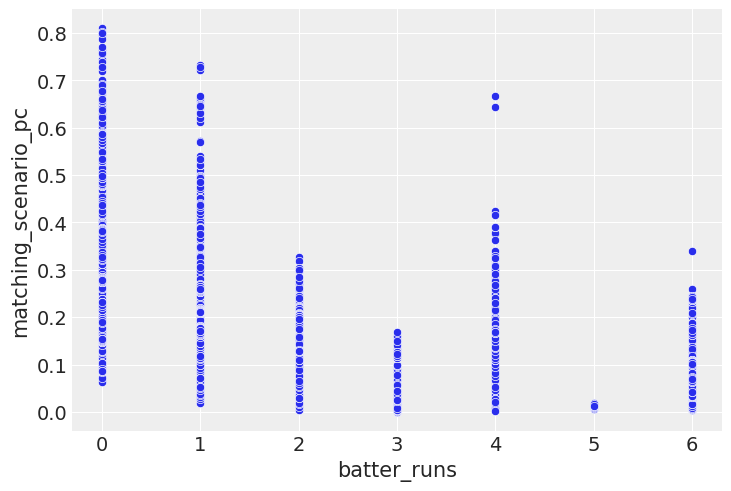

In [1674]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_runs',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='venue', ylabel='matching_scenario_pc'>

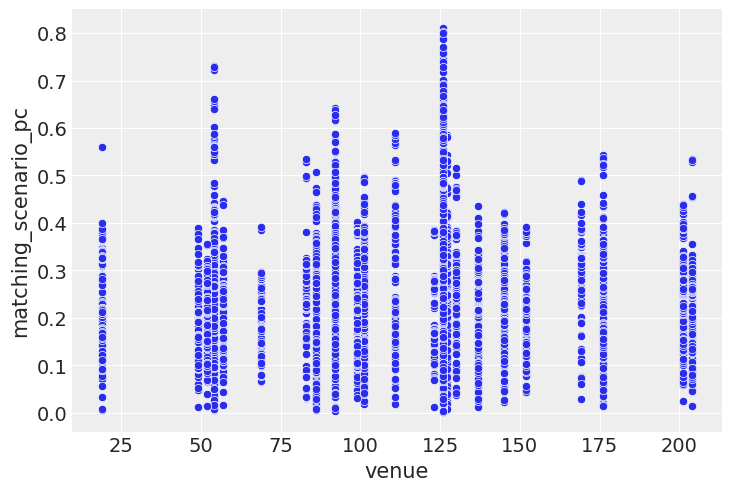

In [1675]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'venue',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='is_legal_delivery', ylabel='matching_scenario_pc'>

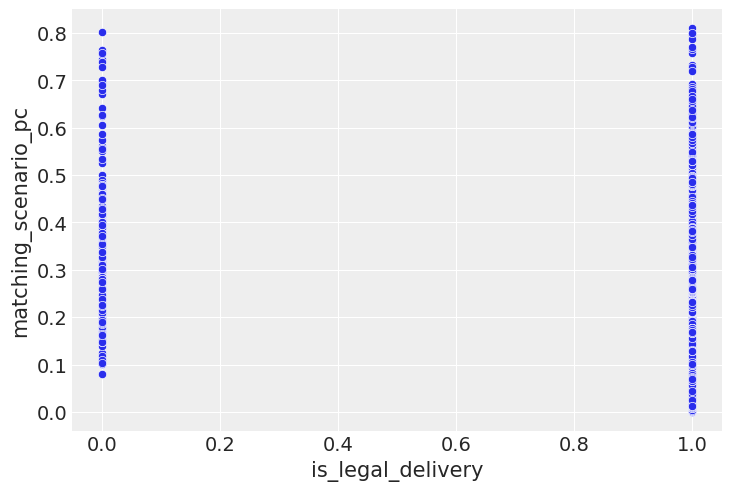

In [1676]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_legal_delivery',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='over', ylabel='matching_scenario_pc'>

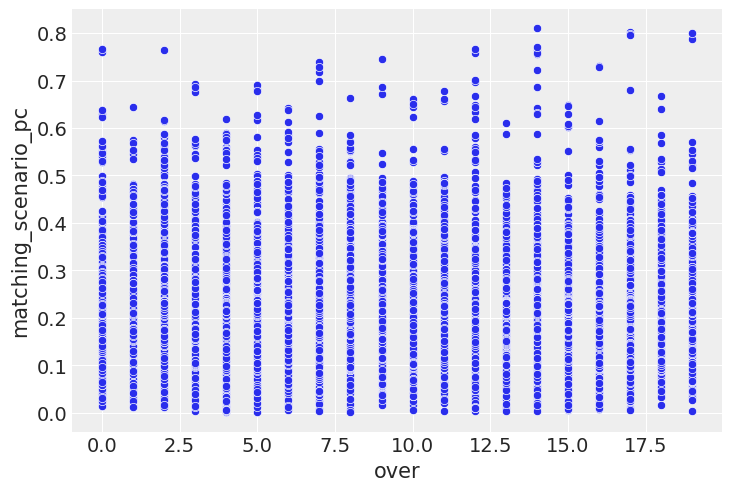

In [1677]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'over',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='inning', ylabel='matching_scenario_pc'>

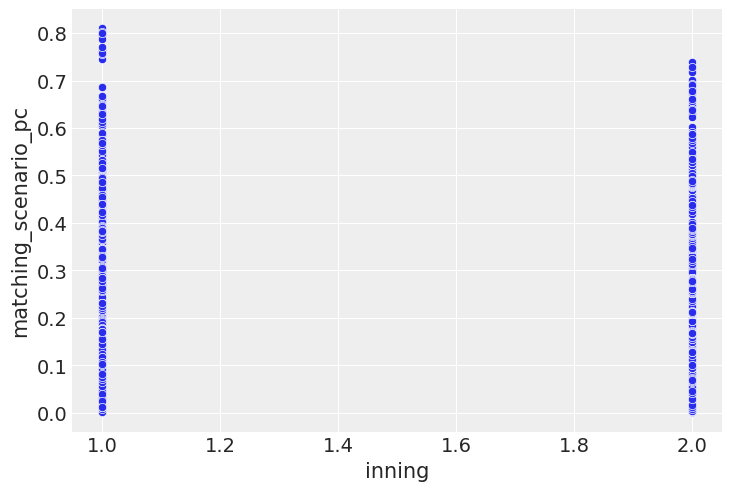

In [1678]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'inning',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='match_key', ylabel='matching_scenario_pc'>

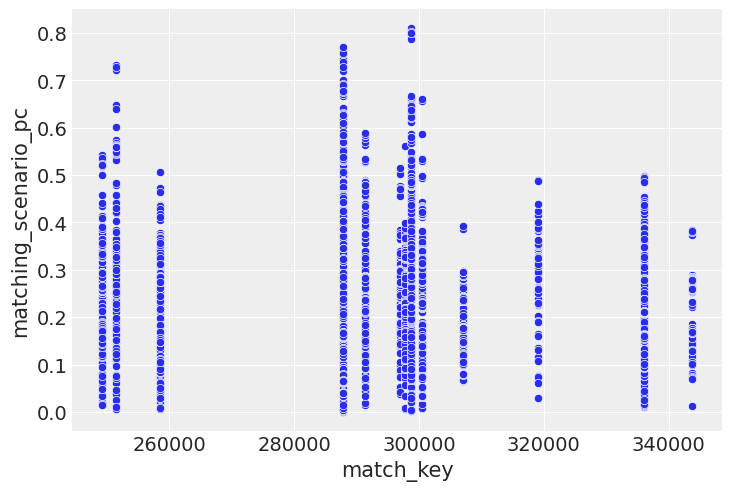

In [1679]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'match_key',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='is_wicket', ylabel='matching_scenario_pc'>

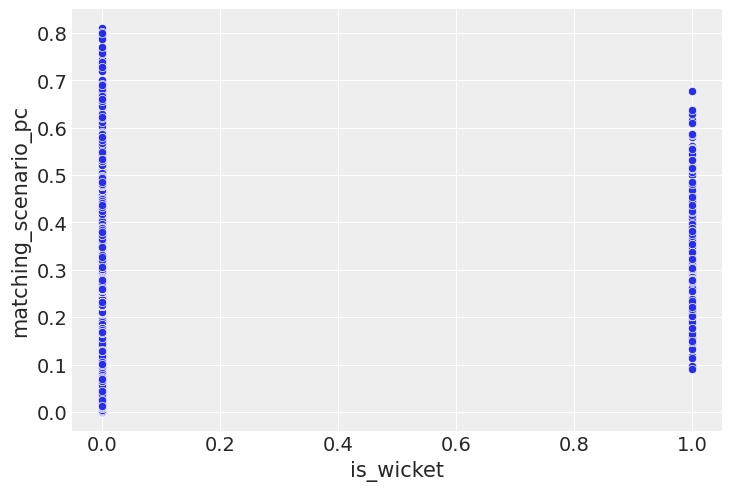

In [1680]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_wicket',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='batter_featured_id', ylabel='matching_scenario_pc'>

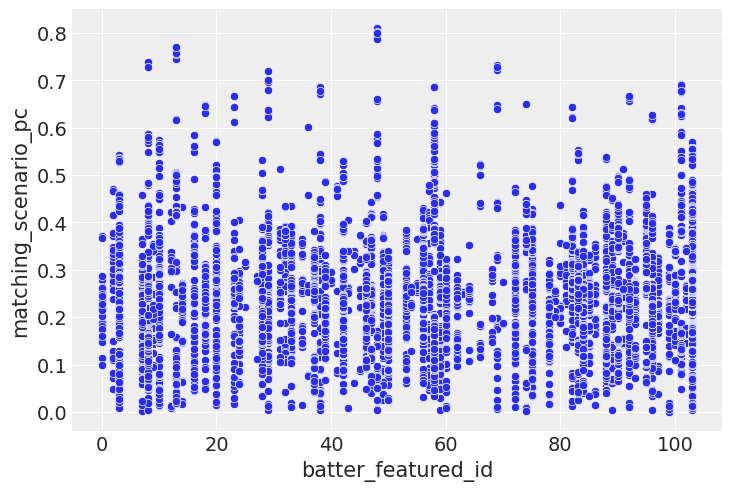

In [1682]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_featured_id',
    y = 'matching_scenario_pc'
)

In [1572]:
ball_gb = (
    idata.predictions['batter_runs_outcome_by_ball_and_innings_rv']
    .groupby('ball_ids')
)

In [1576]:
for ds in ball_gb:
    get_match_scenario_pc(ds)
    if ds[0] == 2338:
        break

2121 scenarios, 0.53025 for (2328, <xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' (chain: 4,
                                                                draw: 1000)>
array([[1, 0, 2, ..., 1, 0, 0],
       [0, 2, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 3, 3],
       [0, 1, 4, ..., 2, 0, 1]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    ball_ids  int64 2328)
2133 scenarios, 0.53325 for (2329, <xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' (chain: 4,
                                                                draw: 1000)>
array([[0, 0, 4, ..., 0, 4, 0],
       [0, 2, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 4, ..., 2, 0, 1]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    ball_ids  int64 2329)
329 scenarios, 0.08225 for (2330, <xarray.DataArray 'batte

In [1555]:
(ds[1] == 0).to_dataframe().batter_runs_outcome_by_ball_and_innings_rv.sum()

2121

In [1551]:
test_combined_no_idx.iloc[ds[0]-2328].batter_runs

0

In [1549]:
get_match_scenario_pc(ds)

<xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' ()>
array(0.53)
Coordinates:
    ball_ids  int64 2328

In [1526]:
(ds[1] == test_combined_no_idx.iloc[0].batter_runs).sum()

<xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' ()>
array(2121)
Coordinates:
    ball_ids  int64 2328

In [1520]:
(ds[1] == test_combined_no_idx.iloc[0].batter_runs).sum()

<xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' ()>
array(2121)
Coordinates:
    ball_ids  int64 2328

In [1500]:
player_view = (
    idata
    .isel(ball_ids = np.where(selected_batters_ball_idx)[0].tolist())
)

IndexError: index 2328 is out of bounds for axis 0 with size 2328

In [1499]:
player_view.to_dataframe()

batter_runs_outcome_by_ball_and_innings_rv
chain draw ball_ids                                            
0     0    2336                                               4
           2337                                               4
           2338                                               0
           2339                                               4
           2340                                               4
...                                                         ...
3     999  25890                                              2
           25891                                              2
           25892                                              2
           25893                                              2
           25894                                              2

[62308000 rows x 1 columns]

In [1484]:
player_view = (
    idata.posterior["batter_runs_outcome_alpha_by_batter"]
    .sel(batter_featured_id = ['non_frequent_player'])
)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

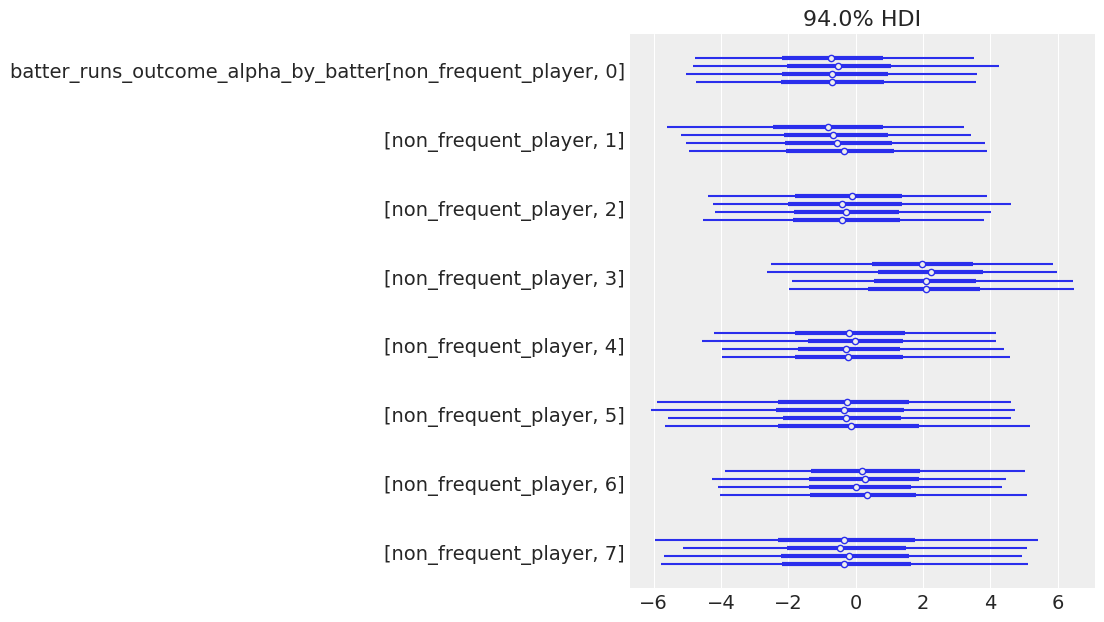

In [1485]:
az.plot_forest(
    player_view
)

In [1311]:
train_combined_df.query('batter_runs == 6').bowler_featured_id.value_counts(normalize=True)

1378    0.0750
355     0.0625
12      0.0625
646     0.0375
418     0.0375
864     0.0375
436     0.0375
538     0.0250
1154    0.0250
797     0.0250
811     0.0250
1231    0.0250
42      0.0250
1175    0.0250
512     0.0250
138     0.0250
608     0.0250
423     0.0250
1263    0.0125
475     0.0125
1203    0.0125
496     0.0125
11      0.0125
874     0.0125
1137    0.0125
793     0.0125
563     0.0125
219     0.0125
1350    0.0125
1073    0.0125
611     0.0125
863     0.0125
543     0.0125
306     0.0125
786     0.0125
788     0.0125
486     0.0125
290     0.0125
1215    0.0125
1105    0.0125
733     0.0125
574     0.0125
115     0.0125
1257    0.0125
702     0.0125
1094    0.0125
1247    0.0125
1048    0.0125
Name: bowler_featured_id, dtype: float64

In [1310]:
train_combined_df.query('batter_runs == 6').batter_featured_id.value_counts(normalize=True)

75     0.0875
10     0.0750
103    0.0750
22     0.0625
29     0.0500
92     0.0500
42     0.0500
7      0.0500
57     0.0500
59     0.0375
84     0.0375
85     0.0250
28     0.0250
39     0.0250
36     0.0250
9      0.0250
72     0.0250
45     0.0125
49     0.0125
69     0.0125
8      0.0125
96     0.0125
21     0.0125
51     0.0125
34     0.0125
19     0.0125
89     0.0125
65     0.0125
14     0.0125
99     0.0125
67     0.0125
78     0.0125
68     0.0125
16     0.0125
47     0.0125
Name: batter_featured_id, dtype: float64

In [1308]:
test_combined_df.query('batter_runs == 6').batter_featured_id.value_counts(normalize=True)

103    0.545889
84     0.036329
3      0.030593
96     0.024857
42     0.022945
10     0.021033
58     0.018164
90     0.017208
7      0.014340
59     0.013384
16     0.012428
72     0.012428
78     0.012428
88     0.011472
89     0.010516
20     0.010516
46     0.010516
13     0.010516
38     0.009560
29     0.009560
101    0.008604
28     0.008604
50     0.008604
37     0.007648
33     0.007648
92     0.007648
49     0.006692
18     0.006692
62     0.006692
95     0.006692
56     0.005736
24     0.004780
60     0.004780
48     0.003824
75     0.003824
39     0.003824
47     0.003824
31     0.002868
83     0.002868
53     0.002868
8      0.002868
86     0.002868
93     0.001912
0      0.001912
23     0.001912
85     0.001912
74     0.001912
9      0.001912
82     0.001912
2      0.001912
57     0.001912
99     0.001912
97     0.000956
44     0.000956
100    0.000956
69     0.000956
32     0.000956
14     0.000956
Name: batter_featured_id, dtype: float64

In [1312]:
test_combined_df.query('batter_runs == 6').bowler_featured_id.value_counts(normalize=True)

1378    0.545889
1175    0.012428
1229    0.012428
952     0.009560
586     0.009560
          ...   
798     0.000956
392     0.000956
1292    0.000956
646     0.000956
1305    0.000956
Name: bowler_featured_id, Length: 140, dtype: float64

In [1315]:
test_combined_df.batter_featured_id.value_counts(normalize=True)

103    0.570544
3      0.021640
28     0.020325
58     0.020113
84     0.018288
         ...   
27     0.000212
44     0.000212
25     0.000170
70     0.000127
63     0.000127
Name: batter_featured_id, Length: 79, dtype: float64

In [1316]:
test_combined_df.bowler_featured_id.value_counts(normalize=True)

1378    0.570544
496     0.009505
1203    0.009208
1061    0.008826
1175    0.008444
          ...   
1227    0.000127
467     0.000085
1226    0.000042
1024    0.000042
1029    0.000042
Name: bowler_featured_id, Length: 184, dtype: float64

In [1317]:
test_combined_df

batter_runs  extras  is_legal_delivery  is_wicket  \
match_key inning over ball                                                      
249227    1      0    1               0       0                  1          0   
                      2               0       1                  0          0   
                      3               4       0                  1          0   
                      4               0       0                  1          0   
                      5               0       1                  0          0   
...                                 ...     ...                ...        ...   
343764    2      15   3               0       1                  0          0   
                      4               0       0                  1          0   
                      5               1       0                  1          0   
                      6               0       0                  1          1   
                      7               0       0                  1          1   

                            wides  noballs  dismissal_kind  is_direct_runout  \
match_key inning over ball                                                     
249227    1      0    1        -1       -1              -1                -1   
                      2         0       -1              -1                -1   
                      3        -1       -1              -1                -1   
                      4        -1       -1              -1                -1   
                      5         0       -1              -1                -1   
...                           ...      ...             ...               ...   
343764    2      15   3        -1        0              -1                -1   
                      4        -1       -1              -1                -1   
                      5        -1       -1              -1                -1   
                      6        -1       -1               1                 0   
                      7        -1       -1               0                 0   

                            batter_featured_id  bowler_featured_id  \
match_key inning over ball                                           
249227    1      0    1                      3                  34   
                      2                      3                  34   
                      3                      3                  34   
                      4                      3                  34   
                      5                      3                  34   
...                                        ...                 ...   
343764    2      15   3                    103                1378   
                      4                    103                1378   
                      5                    103                1378   
                      6                    103                1378   
                      7                    103                1378   

                            batting_team  bowling_team  venue  wickets_fallen  
match_key inning over ball                                                     
249227    1      0    1                5            57    176               0  
                      2                5            57    176               0  
                      3                5            57    176               0  
                      4                5            57    176               0  
                      5                5            57    176               0  
...                                  ...           ...    ...             ...  
343764    2      15   3               10           141    123               8  
                      4               10           141    123               8  
                      5               10           141    123               8  
                      6               10           141    123               9  
                      7               10           141    123 

In [1318]:
COORDS['batter_featured_id'][103]

'non_frequent_player'

In [1408]:
test_match_state_df.query('batter_featured_id == "non_frequent_player"')

batter   bowler batting_team  total_runs  \
match_key inning over ball                                              
249227    1      1    1      MHn991  JAn1002    Australia           4   
                      2      MHn991  JAn1002    Australia           0   
                      3      MHn991  JAn1002    Australia           4   
                      4      MHn991  JAn1002    Australia           2   
                      5      MHn991  JAn1002    Australia           4   
...                             ...      ...          ...         ...   
343764    2      15   3      ARk245  MAd1961   Bangladesh           1   
                      4      ARk245  MAd1961   Bangladesh           0   
                      5      ARk245  MAd1961   Bangladesh           1   
                      6      MMa244  MAd1961   Bangladesh           0   
                      7     SHn1471  MAd1961   Bangladesh           0   

                            is_wicket  target_runs  target_overs  \
match_key inning over ball                                         
249227    1      1    1             0           -1            -1   
                      2             0           -1            -1   
                      3             0           -1            -1   
                      4             0           -1            -1   
                      5             0           -1            -1   
...                               ...          ...           ...   
343764    2      15   3             0          204            20   
                      4             0          204            20   
                      5             0          204            20   
                      6             1          204            20   
                      7             1          204            20   

                            batting_featured_player  bowling_featured_player  \
match_key inning over ball                                                     
249227    1      1    1                       False                    False   
                      2                       False                    False   
                      3                       False                    False   
                      4                       False                    False   
                      5                       False                    False   
...                                             ...                      ...   
343764    2      15   3                       False                    False   
                      4                       False                    False   
                      5                       False                    False   
                      6                       False                    False   
                      7                       False                    False   

                                                    venue  ... bowler_VSi1816  \
match_key inning over ball                                 ...                  
249227    1      1    1     Sydney Cricket Ground, Sydney  ...              0   
                      2     Sydney Cricket Ground, Sydney  ...              0   
                      3     Sydney Cricket Ground, Sydney  ...              0   
                      4     Sydney Cricket Ground, Sydney  ...              0   
                      5     Sydney Cricket Ground, Sydney  ...              0   
...                                                   ...  ...            ...   
343764    2      15   3         National Stadium, Karachi  ...              0   
                      4         National Stadium, Karachi  ...              0   
                      5         National Stadium, Karachi  ...              0   
                      6         National Stadium, Karachi  ...              0   
                      7         National Stadium, Karachi  ...              0   

                            batter_WHs2418  bowler_WHs2418  bowler_WTa1105  \
match_key inning over

In [1410]:
frequent_players_universe.loc['MHn991']

name                                    ML Hayden
New Zealand_num_matches_played                  0
Australia_num_matches_played                    1
England_num_matches_played                      0
Pakistan_num_matches_played                     0
West Indies_num_matches_played                  0
South Africa_num_matches_played                 0
India_num_matches_played                        0
Sri Lanka_num_matches_played                    0
England_num_matches_played_rank              21.0
Australia_num_matches_played_rank            15.0
India_num_matches_played_rank                12.0
New Zealand_num_matches_played_rank          23.0
South Africa_num_matches_played_rank         26.0
Sri Lanka_num_matches_played_rank            16.0
West Indies_num_matches_played_rank          12.0
Pakistan_num_matches_played_rank             12.0
best_rank                                    12.0
featured_player                             False
Name: MHn991, dtype: object

In [1433]:
train_combined_df.venue.value_counts()

126    730
54     493
183    468
22     239
37     238
205    160
Name: venue, dtype: int64

In [1435]:
test_combined_df.venue.value_counts()

126    2682
127    2073
92     1907
101    1716
137    1702
145    1686
152    1672
99     1636
52     1565
57     1330
201    1290
49      892
69      696
86      498
54      473
176     249
83      244
19      240
204     240
123     228
130     227
111     177
169     144
Name: venue, dtype: int64